In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import convolve2d
import cv2
import cv2.ximgproc as ximgproc

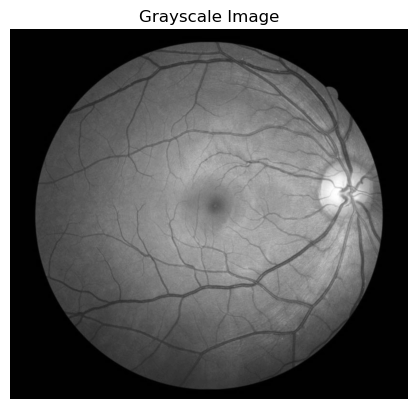

Max Intensity:  247
Min Intensity:  0


In [75]:
# Load the retinal fundus image in grayscale
image_path = 'Fundus.jpeg'
img = cv2.imread(image_path)
if img is None:
    raise IOError("Image not found. Check the image path.")

# Convert to RGB (OpenCV loads images in BGR format by default)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Convert the image to grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

plt.imshow(gray_img, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')
plt.show()
print("Max Intensity: ",np.max(gray_img))
print("Min Intensity: ",np.min(gray_img))

In [76]:
# Create a CLAHE object for comparison
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe_img = clahe.apply(gray_img)
# Apply median filter with 5x5 kernel
clahe_img = cv2.medianBlur(clahe_img, 5)

In [77]:
def perona_malik_diffusion(img, num_iterations=10, kappa=20, gamma=0.1):
    """
    Perform Perona–Malik anisotropic diffusion on a 2D grayscale image.

    Parameters
    ----------
    img            : 2D numpy array (grayscale image)
    num_iterations : int, number of diffusion iterations
    kappa          : float, edge threshold parameter
    gamma          : float, time-step size (should be <= 0.25 for stability in 2D)

    Returns
    -------
    diffused : 2D numpy array, the filtered image
    """

    # Convert to float32 for numerical stability.
    diffused = img.astype(np.float32)

    for _ in range(num_iterations):
        # Compute finite differences (gradients) in the four directions:
        # North gradient (top neighbor)
        gradN = np.roll(diffused,  1, axis=0) - diffused
        # South gradient (bottom neighbor)
        gradS = np.roll(diffused, -1, axis=0) - diffused
        # East gradient (right neighbor)
        gradE = np.roll(diffused, -1, axis=1) - diffused
        # West gradient (left neighbor)
        gradW = np.roll(diffused,  1, axis=1) - diffused

        # Perona–Malik conduction coefficients in each direction.
        # conduction function: c = exp( - (|gradI| / kappa)^2 )
        cN = np.exp(-(gradN/kappa)**2)
        cS = np.exp(-(gradS/kappa)**2)
        cE = np.exp(-(gradE/kappa)**2)
        cW = np.exp(-(gradW/kappa)**2)

        # Update the image by discrete PDE:
        diffused += gamma * (
            cN * gradN + cS * gradS +
            cE * gradE + cW * gradW
        )

    return diffused

In [78]:
niter = 10  # Too few iterations might not remove enough noise; too many can over-smooth or produce artifacts (especially if gamma is large)
kappa = 60  # If you see too much blurring at vessel edges, lower kappa. If you see little noise reduction, increase kappa.
gamma = 0.1  # If you see “ringing” or instability, lower gamma. If you want the same smoothing in fewer iterations, you can raise gamma

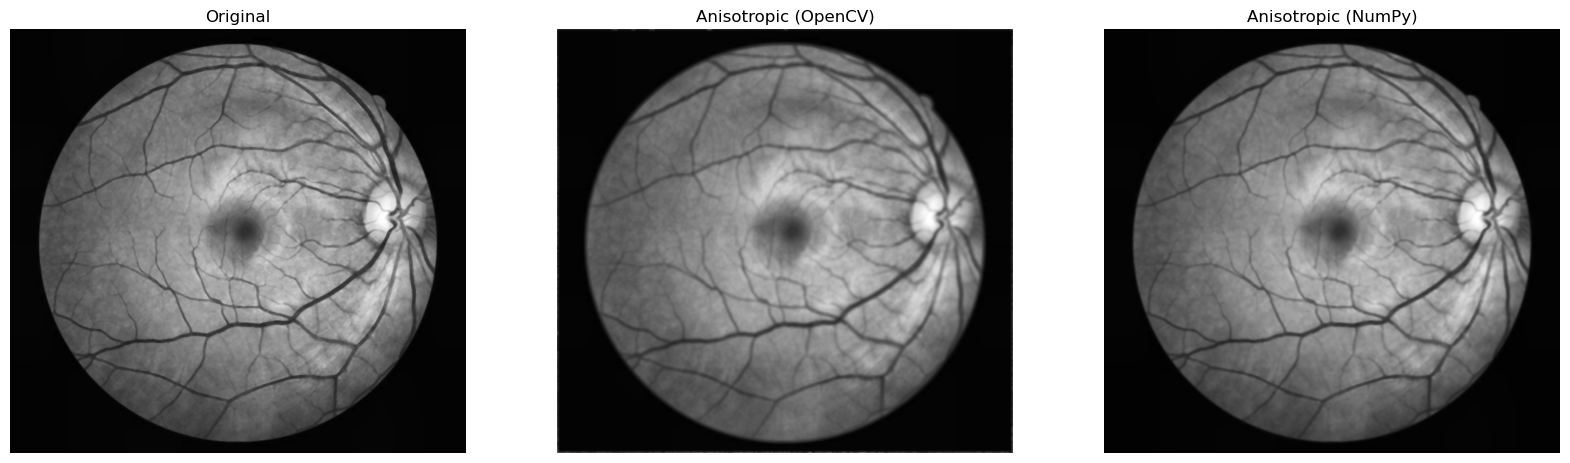

In [79]:
# Apply our pure NumPy Perona–Malik filter
filtered_np = perona_malik_diffusion(clahe_img,
                                     num_iterations=niter,
                                     kappa=kappa,
                                     gamma=gamma)

# alpha ~ "gamma" (time-step), K ~ "kappa", niters = number of iterations
result_cv = ximgproc.anisotropicDiffusion(img,
                                          alpha=gamma,  # like gamma
                                          K=kappa,       # like kappa
                                          niters=niter)  # number of iterations
result_cv = cv2.cvtColor(result_cv, cv2.COLOR_RGB2GRAY)
result_cv = clahe.apply(result_cv)
# Compare original and filtered
plt.figure(figsize=(20,15))
plt.subplot(1,3,1); plt.imshow(clahe_img, cmap='gray'); plt.title('Original'); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(result_cv, cmap='gray'); plt.title('Anisotropic (OpenCV)'); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(filtered_np, cmap='gray'); plt.title("Anisotropic (NumPy)"); plt.axis("off")
plt.show()

In [80]:
def manual_scharr(gray_img):
    """
    Perform manual Scharr filtering using the 3x3 Scharr operator.
    Returns:
      I_x: gradient in x-direction
      I_y: gradient in y-direction
      magnitude: sqrt(I_x^2 + I_y^2)
      orientation: arctan(I_y / I_x), in radians
    """
    # Define Scharr kernels (float64 for accumulation)
    Gx = np.array([[-3, 0, 3],
                   [-10, 0, 10],
                   [ -3, 0, 3]], dtype=np.float64)

    Gy = np.array([[-3, -10, -3],
                   [ 0,   0,  0],
                   [ 3,  10,  3]], dtype=np.float64)

    # Convert image to float64 to avoid overflow in convolution
    img_float = gray_img.astype(np.float64)

    # Convolve with Gx and Gy
    # mode='same' ensures output is the same size as input
    # boundary='symm' handles boundaries by reflecting image
    I_x = convolve2d(img_float, Gx, mode='same', boundary='symm')
    I_y = convolve2d(img_float, Gy, mode='same', boundary='symm')

    # Compute gradient magnitude and orientation
    magnitude = np.sqrt(I_x**2 + I_y**2)
    orientation = np.arctan2(I_y, I_x)  # arctan2 handles sign of x,y

    return I_x, I_y, magnitude, orientation

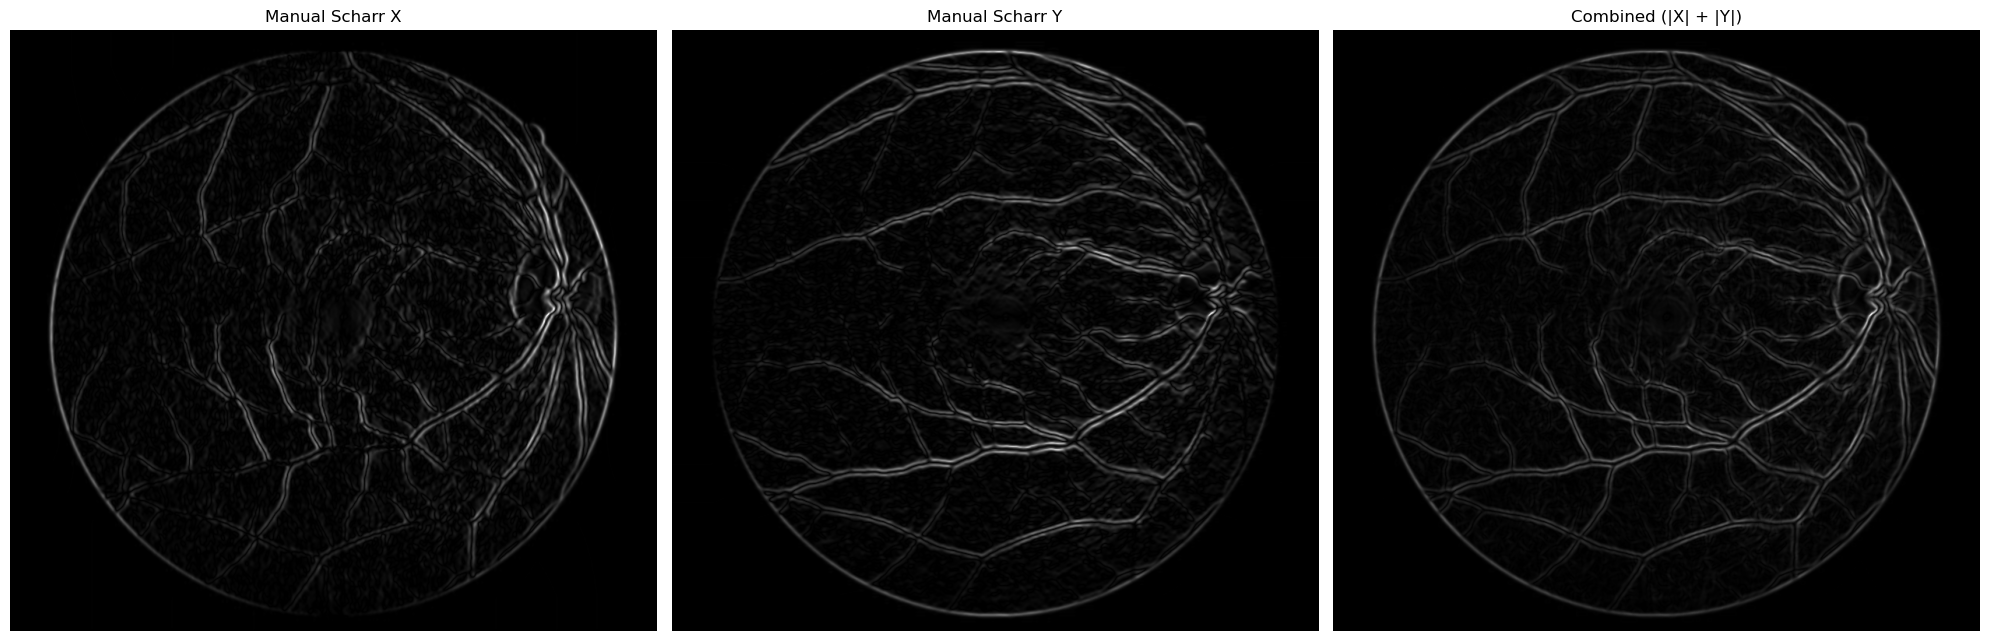

In [81]:
# Manual Scharr Filtering
I_x_manual, I_y_manual, mag_manual, orient_manual = manual_scharr(filtered_np)

# Scharr in X, Y: often contain negative values, so display absolute or scaled version
I_x_disp = np.uint8(255 * (np.abs(I_x_manual) / np.max(np.abs(I_x_manual))))
I_y_disp = np.uint8(255 * (np.abs(I_y_manual) / np.max(np.abs(I_y_manual))))

# Combined version using weighted sum of absolute values
combined = 0.5 * np.abs(I_x_manual) + 0.5 * np.abs(I_y_manual)
combined_disp = np.uint8(255 * (combined / np.max(combined)))

fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# (a) Scharr X
axes[0].imshow(I_x_disp, cmap='gray')
axes[0].set_title('Manual Scharr X')
axes[0].axis('off')

# (b) Scharr Y
axes[1].imshow(I_y_disp, cmap='gray')
axes[1].set_title('Manual Scharr Y')
axes[1].axis('off')

# (c) Combined
axes[2].imshow(combined_disp, cmap='gray')
axes[2].set_title('Combined (|X| + |Y|)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [82]:
def non_maximum_suppression(magnitude, orientation):
    """
    Thin edges by suppressing non-maximal values in the gradient direction.

    Parameters
    ----------
    magnitude : np.ndarray
        Gradient magnitude (same shape as orientation).
    orientation : np.ndarray
        Gradient orientation, in radians.

    Returns
    -------
    nms_result : np.ndarray
        Non-maximum suppressed gradient magnitude (thinned edges).
    """
    # Dimensions
    H, W = magnitude.shape

    # Output array initialized to zeros
    nms_result = np.zeros((H, W), dtype=np.float64)

    # Convert orientation to degrees [0, 180)
    # (We only need the "direction" part for NMS, so 0..180 is enough)
    angle_deg = np.degrees(orientation) % 180

    for i in range(1, H-1):
        for j in range(1, W-1):
            # Current magnitude
            mag_ij = magnitude[i, j]

            # Determine gradient direction, "rounded" to one of four possibilities
            # 0°, 45°, 90°, or 135°
            region = 255  # some sentinel large number
            # We'll compare mag_ij with its neighbors along gradient direction
            if (0 <= angle_deg[i, j] < 22.5) or (157.5 <= angle_deg[i, j] < 180):
                # Approx. horizontal edge
                left_mag  = magnitude[i, j-1]
                right_mag = magnitude[i, j+1]
                if mag_ij >= left_mag and mag_ij >= right_mag:
                    nms_result[i, j] = mag_ij

            elif (22.5 <= angle_deg[i, j] < 67.5):
                # Diagonal 45°
                up_right_mag   = magnitude[i-1, j+1]
                down_left_mag  = magnitude[i+1, j-1]
                if mag_ij >= up_right_mag and mag_ij >= down_left_mag:
                    nms_result[i, j] = mag_ij

            elif (67.5 <= angle_deg[i, j] < 112.5):
                # Vertical edge ~90°
                up_mag   = magnitude[i-1, j]
                down_mag = magnitude[i+1, j]
                if mag_ij >= up_mag and mag_ij >= down_mag:
                    nms_result[i, j] = mag_ij

            elif (112.5 <= angle_deg[i, j] < 157.5):
                # Diagonal 135°
                up_left_mag    = magnitude[i-1, j-1]
                down_right_mag = magnitude[i+1, j+1]
                if mag_ij >= up_left_mag and mag_ij >= down_right_mag:
                    nms_result[i, j] = mag_ij

    return nms_result

def hysteresis_thresholding(nms_mag, low_ratio=0.1, high_ratio=0.2):
    """
    Apply hysteresis thresholding to a non-maximum suppressed magnitude image.

    Parameters
    ----------
    nms_mag : np.ndarray
        Non-maximum suppressed magnitude.
    low_ratio : float
        Fraction of the maximum magnitude to use as the low threshold.
    high_ratio : float
        Fraction of the maximum magnitude to use as the high threshold.

    Returns
    -------
    edges : np.ndarray
        Binary edge map (dtype=bool).
    """
    H, W = nms_mag.shape
    edges = np.zeros((H, W), dtype=bool)

    # Compute absolute thresholds from ratios
    high_thresh = nms_mag.max() * high_ratio
    low_thresh  = nms_mag.max() * low_ratio

    # Mark strong and weak edges
    strong_i, strong_j = np.where(nms_mag >= high_thresh)
    weak_i, weak_j   = np.where((nms_mag <= high_thresh) & (nms_mag >= low_thresh))

    # Result array to fill:
    # 0 = not an edge, 1 = weak edge, 2 = strong edge
    thresholded = np.zeros((H, W), dtype=np.uint8)

    thresholded[strong_i, strong_j] = 2
    thresholded[weak_i, weak_j]     = 1

    # Use a stack/queue to traverse connected pixels
    # (All strong edges are edges by definition.)
    # Then we look for any weak edges connected to these strong edges.
    stack = list(zip(strong_i, strong_j))

    # Offsets for the 8 neighbors
    neighbors = [(-1, -1), (-1, 0), (-1, 1),
                 ( 0, -1),          ( 0, 1),
                 ( 1, -1), ( 1, 0), ( 1, 1)]

    while stack:
        i, j = stack.pop()

        # Explore neighbors
        for di, dj in neighbors:
            ni = i + di
            nj = j + dj
            if (0 <= ni < H) and (0 <= nj < W):
                # If neighbor is a weak edge, promote it to strong
                if thresholded[ni, nj] == 1:
                    thresholded[ni, nj] = 2
                    stack.append((ni, nj))

    # Final edges are all pixels labeled '2'
    edges[thresholded == 2] = True
    return edges

def scharr_edge_detection_hysteresis(gray_img, low_ratio=0.1, high_ratio=0.2):
    """
    Complete Scharr-based edge detection pipeline with hysteresis thresholding.

    Steps:
      1. Scharr gradient computation.
      2. Non-maximum suppression.
      3. Double-threshold & hysteresis.

    Parameters
    ----------
    gray_img : np.ndarray
        Grayscale image (2D).
    low_ratio : float
        Low threshold ratio (relative to max magnitude).
    high_ratio : float
        High threshold ratio (relative to max magnitude).

    Returns
    -------
    edges : np.ndarray
        Binary edge map (bool).
    I_x : np.ndarray
        Scharr gradient (x-direction).
    I_y : np.ndarray
        Scharr gradient (y-direction).
    magnitude : np.ndarray
        Gradient magnitude.
    orientation : np.ndarray
        Gradient orientation in radians.
    """
    # 1. Scharr gradients
    I_x, I_y, magnitude, orientation = manual_scharr(gray_img)
    # 2. Non-Maximum Suppression
    nms_mag = non_maximum_suppression(magnitude, orientation)
    # 3. Hysteresis Thresholding
    edges = hysteresis_thresholding(nms_mag, low_ratio=low_ratio, high_ratio=high_ratio)
    return edges, I_x, I_y, magnitude, orientation

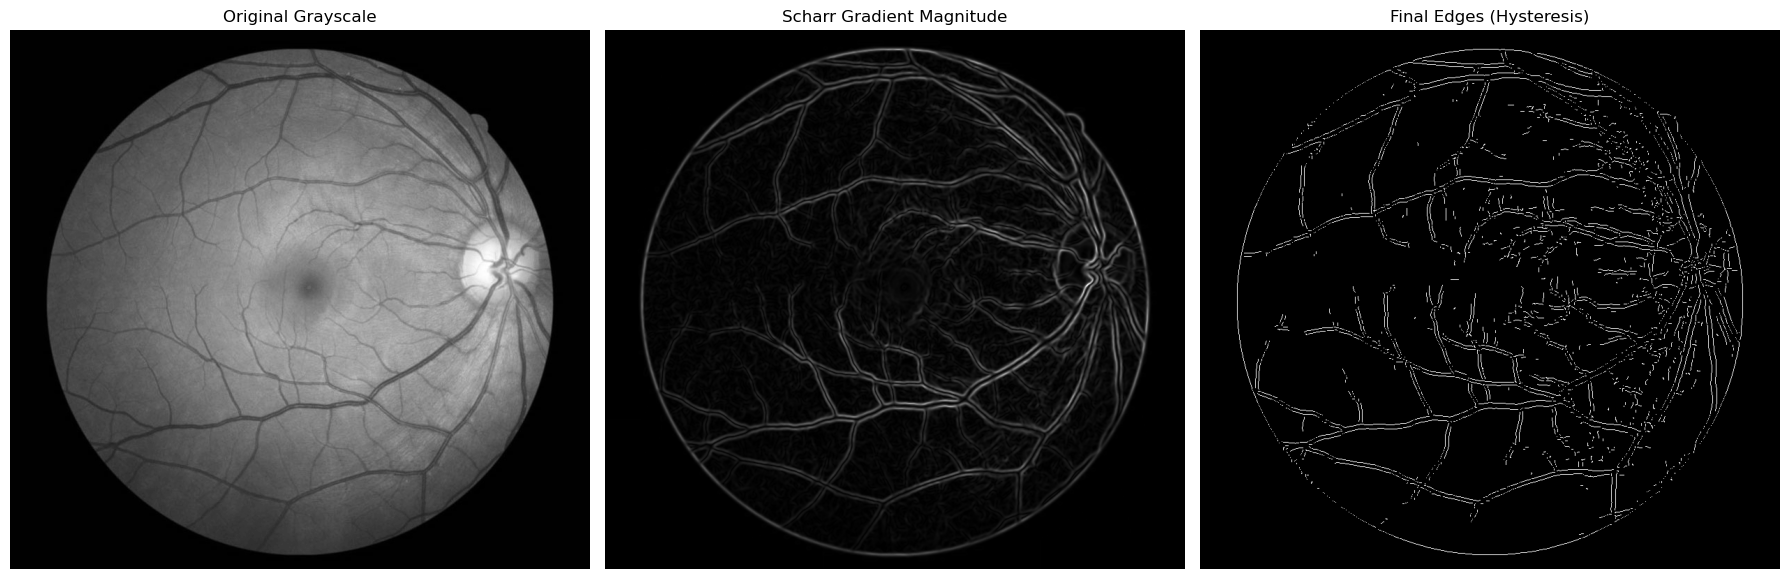

In [84]:
# 2. Run Scharr + Hysteresis Edge Detection
edges, I_x, I_y, magnitude, orientation = scharr_edge_detection_hysteresis(
    filtered_np,
    low_ratio=0.07,  # Adjust these for your use-case
    high_ratio=0.1
)

# 3. Visualization
# Display the NMS magnitude (for reference) and the final edges
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# a) Original
axs[0].imshow(gray_img, cmap='gray')
axs[0].set_title("Original Grayscale")
axs[0].axis('off')

# b) Gradient Magnitude
mag_norm = (magnitude / np.max(magnitude + 1e-8)) * 255
axs[1].imshow(mag_norm.astype(np.uint8), cmap='gray')
axs[1].set_title("Scharr Gradient Magnitude")
axs[1].axis('off')

# c) Final Edges (hysteresis)
axs[2].imshow(edges, cmap='gray')
axs[2].set_title("Final Edges (Hysteresis)")
axs[2].axis('off')

plt.tight_layout()
plt.show()